<a href="https://www.kaggle.com/code/angelchaudhary/signal-decomposition-what-models-really-learn?scriptVersionId=290389787" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# When a model performs well, is it actually learning meaningful structure or just overfitting to seasonality?

# Introduction

Most forecasting models are trained on raw time series without explicitly understanding what drives the signal. However, real-world time series are usually a combination of long term trends, repeating seasonal patterns and random noise.
 
**What We Do in This Case Study**  
We decompose a time series into **trend**, **seasonality**, and **residuals**, then analyze how much each component contributes to model performance.

## Approach 
We first break the signal into interpretable components, visualize them, and then evaluate how models behave when trained on different combinations of these components. This helps us identify whether the model learns genuine patterns or relies heavily on seasonal shortcuts.

The goal is not better accuracy but better understanding before predicting.


# LET'S DO IT!!!
![FUNNY GIF](https://media.giphy.com/media/v1.Y2lkPWVjZjA1ZTQ3ZzNhNnVubjIxZHVyaXZjcHFhZzZ3cmM2Y3RiODczZW95aDQwbjNzNSZlcD12MV9naWZzX3NlYXJjaCZjdD1n/OBt5V50EL03bZBs9MZ/giphy.gif)

In [1]:
import kagglehub

path = kagglehub.dataset_download("rassiem/monthly-car-sales")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/monthly-car-sales


In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv("/kaggle/input/monthly-car-sales/monthly-car-sales.csv")
df.head(3)

,Month,Sales
0,1960-01,6550
1,1960-02,8728
2,1960-03,12026


In [3]:
df.describe()

,Sales
count,108.000000
mean,14595.111111
std,4525.213913
min,5568.000000
25%,11391.250000
50%,14076.000000
75%,17595.750000
max,26099.000000


## Dataset Check

The dataset contains monthly car sales data with a clear time ordering and a single numeric target variable.

It shows:
- 108 monthly observations spanning multiple years
- No missing values
- Sales values are continuous and strictly positive

At this stage, we intentionally avoid any feature engineering or transformations. The goal is to first understand the raw signal structure before applying decomposition or modeling techniques.

## Raw Time Series Visualization

Before decomposing the signal, we'll first visualize the raw time series.

This is to ensure to answer these basic questions:
- Is there a visible long-term trend?
- Does seasonality repeat over time?
- How noisy or smooth is the signal?

Seeing the data before applying any method builds intuition and prevents blindly trusting decomposition outputs.

In [4]:
import matplotlib.pyplot as plt

df['Month'] = pd.to_datetime(df['Month'])
df = df.set_index('Month')
df.describe()

,Sales
count,108.000000
mean,14595.111111
std,4525.213913
min,5568.000000
25%,11391.250000
50%,14076.000000
75%,17595.750000
max,26099.000000


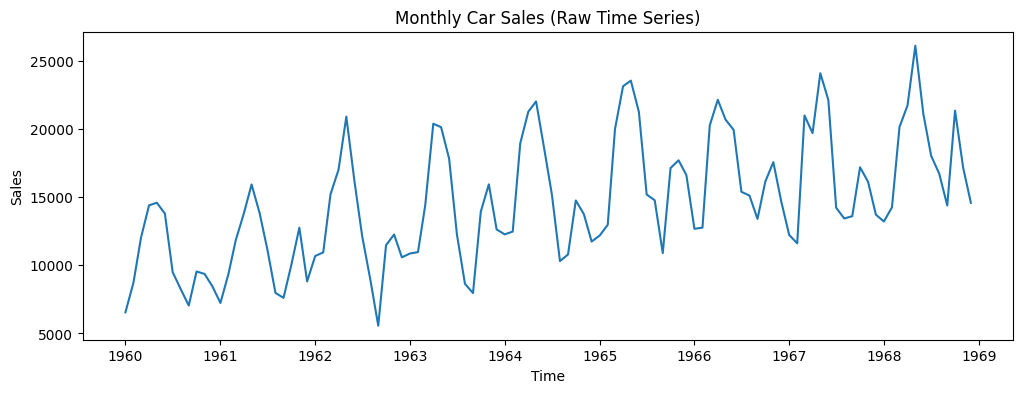

In [5]:
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['Sales'])
plt.title("Monthly Car Sales (Raw Time Series)")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.show()

### Observations
The raw time series shows a clear upward trend in monthly car sales over the years, indicating sustained growth in demand. Superimposed on this trend is a strong and repeating yearly pattern, suggesting pronounced seasonality where certain months consistently experience higher or lower sales. In addition to these structured patterns, short-term fluctuations are present, reflecting irregular noise or transient effects that are not explained by trend or seasonality alone. This confirms that the observed signal is a mixture of multiple components rather than a single homogeneous process.

## Signal Decomposition

The raw time series is a combination of multiple underlying components. To understand what drives the signal, we explicitly decompose it into:

- **Trend**: long-term movement in sales
- **Seasonality**: repeating yearly patterns
- **Residuals**: irregular fluctuations not explained by trend or seasonality

We use STL (Seasonal-Trend decomposition using LOESS) because it is robust and works well even when trend and seasonality change slowly over time.

In [6]:
from statsmodels.tsa.seasonal import STL

# STL decomposition
stl = STL(df['Sales'], period=12)
result = stl.fit()

trend = result.trend
seasonal = result.seasonal
residual = result.resid

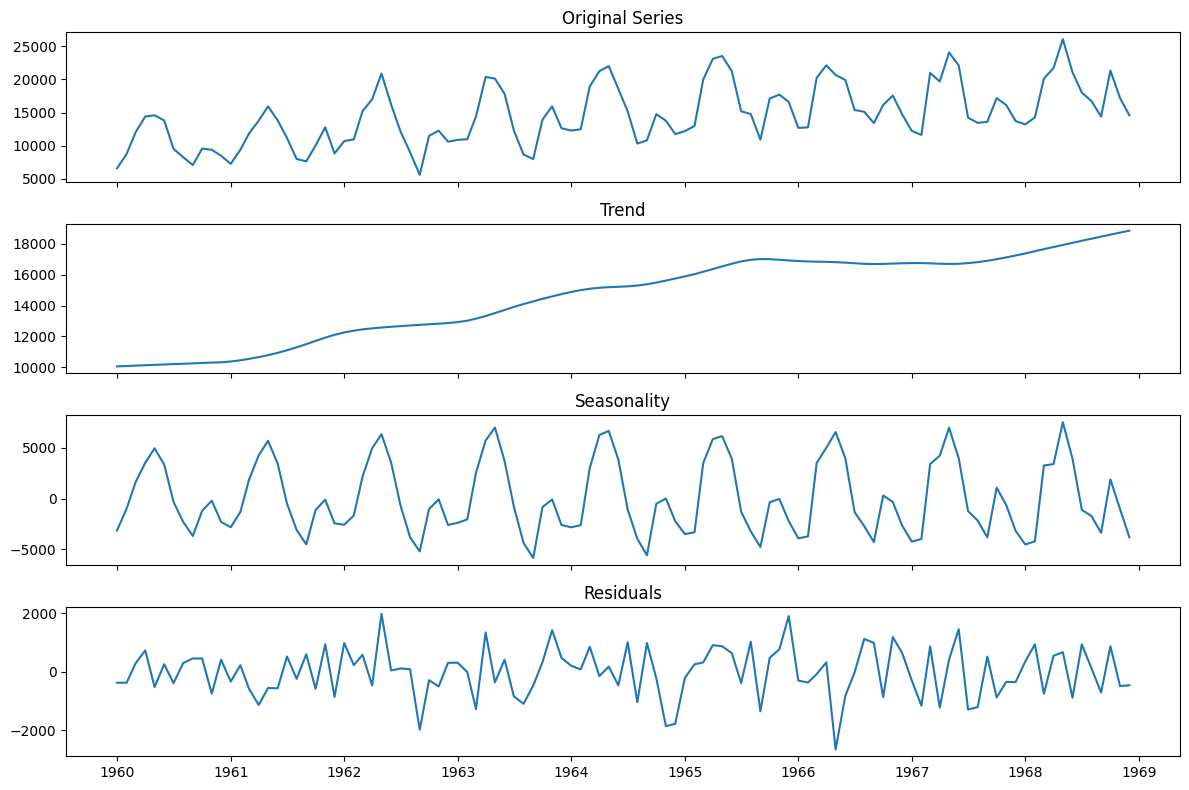

In [7]:
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

axes[0].plot(df['Sales'])
axes[0].set_title("Original Series")
axes[1].plot(trend)
axes[1].set_title("Trend")
axes[2].plot(seasonal)
axes[2].set_title("Seasonality")
axes[3].plot(residual)
axes[3].set_title("Residuals")
plt.tight_layout()
plt.show()

### Component-wise Observations
The decomposition reveals that the long-term growth in car sales is smooth and gradual, captured entirely by the trend component. 
- The seasonal component shows a strong and highly consistent yearly pattern, with similar peaks and troughs repeating across all years. This indicates that a large fraction of the variation in the original series is explained by seasonality alone.
- The residuals are comparatively small in magnitude and centered around zero, suggesting that most of the structured signal has already been removed by the trend and seasonal components. What remains appears largely irregular, with no obvious repeating pattern.

## Deseasonalizing the Series

The decomposition showed that seasonality explains a large portion of the variation in the data. To test whether models rely heavily on this repeating pattern, we create a deseasonalized version of the series by removing the seasonal component.
This allows us to compare model behavior on:
- the **original series** (trend + seasonality + noise)
- the **deseasonalized series** (trend + noise)

If performance drops significantly after removing seasonality, it suggests that the model was primarily learning seasonal shortcuts.

In [8]:
# deseasonalized series
df['Sales_deseasonalized'] = df['Sales'] - seasonal
df[['Sales', 'Sales_deseasonalized']].head()

,Sales,Sales_deseasonalized
Month,,
1960-01-01,6550,9689.405933
1960-02-01,8728,9716.315996
1960-03-01,12026,10409.497202
1960-04-01,14395,10873.478956
1960-05-01,14587,9644.441410


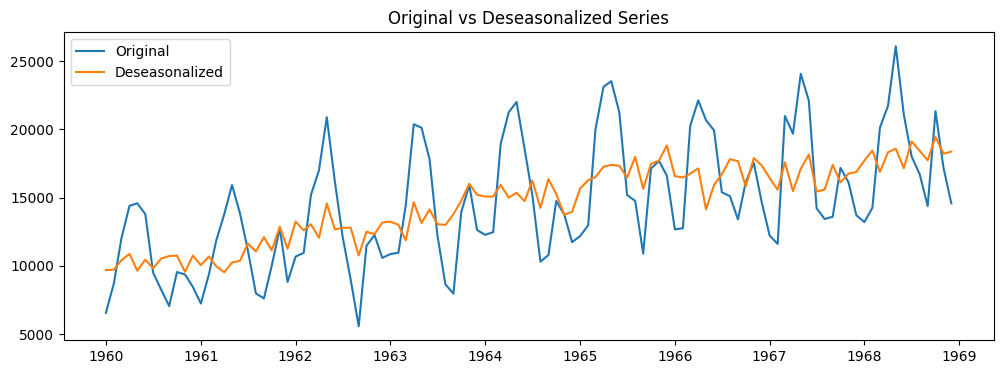

In [9]:
plt.figure(figsize=(12, 4))
plt.plot(df.index, df['Sales'], label='Original')
plt.plot(df.index, df['Sales_deseasonalized'], label='Deseasonalized')
plt.title("Original vs Deseasonalized Series")
plt.legend()
plt.show()

### Observation
The deseasonalized series removes the sharp, repeating peaks and troughs seen in the original data, resulting in a much smoother signal dominated by long-term growth and mild irregular fluctuations. This highlights how strongly seasonality shapes the original series, often accounting for the most visually prominent changes. What remains after deseasonalization is a subtler signal that is inherently harder to predict, suggesting that any strong model performance on the raw series may largely be driven by learning seasonal repetition rather than deeper demand dynamics.

## Forecasting Setup

To test what the model actually learns, we set up a simple one-step-ahead forecasting task.

We train the same baseline model on:
1. the **original series**
2. the **deseasonalized series**

Both models use identical lag-based features and are evaluated on the same time-based split. This isolates the effect of seasonality on model performance.

In [10]:
# lag features
def create_lag_features(series, lags=12):
    df_lag = pd.DataFrame(series)
    for lag in range(1, lags + 1):
        df_lag[f'lag_{lag}'] = df_lag.iloc[:, 0].shift(lag)
    return df_lag.dropna()

In [11]:
# prepare the dataset

# original series
orig_data = create_lag_features(df['Sales'])
# deseasonalized series
deseas_data = create_lag_features(df['Sales_deseasonalized'])
# train-test split (time-based)
split_idx = int(len(orig_data) * 0.8)

X_orig_train = orig_data.iloc[:split_idx, 1:]
y_orig_train = orig_data.iloc[:split_idx, 0]
X_orig_test  = orig_data.iloc[split_idx:, 1:]
y_orig_test  = orig_data.iloc[split_idx:, 0]
X_des_train = deseas_data.iloc[:split_idx, 1:]
y_des_train = deseas_data.iloc[:split_idx, 0]
X_des_test  = deseas_data.iloc[split_idx:, 1:]
y_des_test  = deseas_data.iloc[split_idx:, 0]

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

model_orig = LinearRegression()
model_des  = LinearRegression()

model_orig.fit(X_orig_train, y_orig_train)
model_des.fit(X_des_train, y_des_train)

pred_orig = model_orig.predict(X_orig_test)
pred_des  = model_des.predict(X_des_test)

mae_orig = mean_absolute_error(y_orig_test, pred_orig)
mae_des  = mean_absolute_error(y_des_test, pred_des)

mae_orig, mae_des

(1418.5991216012371, 890.3157982090879)

### Observation
The model trained on the deseasonalized series achieves a lower mean absolute error than the model trained on the original series. This indicates that the strong seasonal component introduces variability that the simple lag-based linear model does not capture effectively. Once seasonality is removed, the remaining signal becomes smoother and easier to model, leading to improved predictive accuracy. This suggests that seasonality is a dominant but structurally different component that requires explicit handling rather than being implicitly learned by a generic model.

## Why This Case Study Matters

Time series models often show strong performance simply because they exploit repeating patterns. Without understanding the structure explained by trend, seasonality, and residuals, it is easy to misinterpret model accuracy as genuine learning.

This case study demonstrates how decomposition can reveal whether a model is struggling due to lack of signal, or because it is not designed to handle dominant components such as seasonality. Understanding the signal before modeling leads to better modeling choices and more trustworthy forecasts.

## When to Use Signal Decomposition

Signal decomposition is especially useful when:
- the series shows repeating cycles or seasonal patterns
- model performance is unexpectedly high or low
- predictions rely heavily on short-term fluctuations
- interpretability matters as much as accuracy

Decomposing the signal early helps prevent misdiagnosing model behavior and guides more appropriate modeling decisions.

## Conclusion

Decomposition provides a simple yet powerful lens for understanding time series data. By separating structure from noise, it becomes easier to evaluate what models are truly learning and to avoid drawing misleading conclusions from performance metrics alone.